## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [111]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import IPython.display as ipd

import sys
sys.path.append('hifigan/')
import numpy as np
import torch
import librosa
import librosa.display
import math
import json
import os

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from text.cleaners import transliteration_ua_cleaners, english_cleaners, transliteration_cleaners,transliteration_cleaners_with_stress
from text.rudict import RuDict


from hifigan.meldataset import MAX_WAV_VALUE
from hifigan.models import Generator
from hifigan.env import AttrDict

In [112]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')
    plt.savefig('out.png')
    ipd.display(ipd.Image('out.png'))

In [113]:
hparams = create_hparams()
hparams.sampling_rate = 22050

In [140]:
checkpoint_path = "outdir/checkpoint_34000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

In [141]:

text = "zamo+k, za+mok, zha+rkoe, zharko+e, ukraina i ukrai+na".lower()
print(transliteration_cleaners_with_stress(text))
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners_with_stress']))[None, :]
print(sequence)
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

Szamo+k, za+mok, zha+rkoe, zharko+e, ukraina i ukrai+na.E
[[12 39 14 26 28 40 24  6 11 39 14 40 26 28 24  6 11 39 21 14 40 31 24 28
  18  6 11 39 21 14 31 24 28 40 18  6 11 34 24 31 14 22 27 14 11 22 11 34
  24 31 14 22 40 27 14  7 13]]


In [148]:
%%time
# np.random.seed(16)

_, mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence,seed=None)

Warning! Reached max decoder steps
CPU times: user 4.22 s, sys: 0 ns, total: 4.22 s
Wall time: 4.22 s


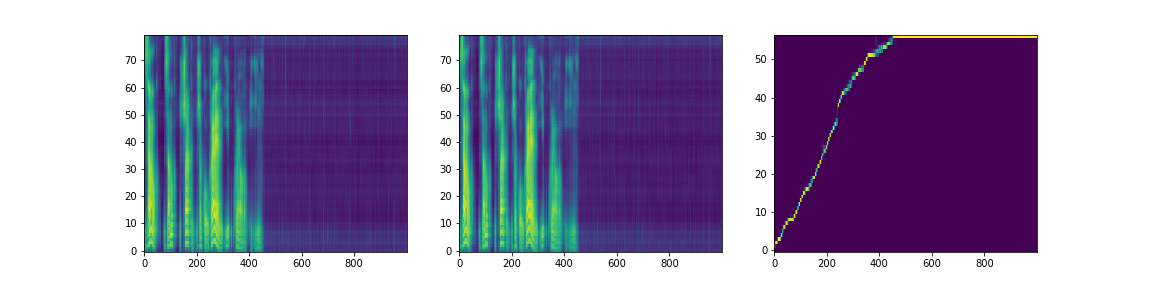

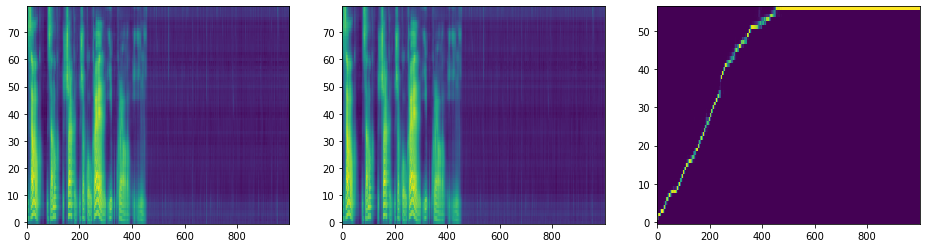

In [149]:
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

In [150]:
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

def inference(mel):
    device = torch.device('cuda')
    with open('hifigan/config.json') as fp:
        json_config = json.load(fp)
        h = AttrDict(json_config)
    generator = Generator(h).to(device)

    state_dict_g = load_checkpoint("hifigan/g_02500000", device)
    generator.load_state_dict(state_dict_g['generator'])

    generator.eval()
    generator.remove_weight_norm()
    with torch.no_grad():
        y_g_hat = generator(mel)
        audio = y_g_hat.squeeze()
        audio = audio * MAX_WAV_VALUE
        audio = audio.detach().cpu().numpy()#.astype('int16')

        return audio
    
mel = mel_outputs_postnet.type(torch.float32)
audio = inference(mel)
ipd.Audio(audio, rate=hparams.sampling_rate)

Loading 'hifigan/g_02500000'
Complete.
Removing weight norm...
